# Post analysis script

First created: 2018-08-06    
By: Hirotaka Iwaki     


This is to organize the meta-analysis results and provide some information for interpretations.    
Trying to target two sets of variants.    
1. The set of variants exceed the 5E-8 threshold in any of the meta-analysis.
2. The 92 recently identified PD risk variants.

### Extracting interesting variants and get p-value for each outcomes
1. Get the list of significant $5E^{-8}$ variants across outcomes
2. Add newly identified $92$ variants (Meta5)
3. Add $31$ variants in used in a recent PD-progression analysis.
4. Take p-values of the variants from the analysis for each outcome
5. Create cross-tab of $-log_{10}P$ for $variants \times outcomes$

In [ ]:
# The following lines should be uncommented  before starting the following
# rm -rf post
# mkdir -p post
# rm -rf /data/LNG/Hirotaka/progGWAS/meta/rvtest/MMSE #MMSE_baseline is deleted.

In [14]:
%%bash

complete step5 - rvtest 
complete step5 - surv 


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last



In [6]:
%%bash
# step1: Get the list of variants
for ANALYSIS in "surv" "rvtest";do
    mkdir post/$ANALYSIS
    RES_FOLDER="/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS"
    for OUTCOME in $(ls $RES_FOLDER);do
        awk '$10 < 5e-8 {print $1}' $RES_FOLDER/$OUTCOME/meta2.tbl > post/$ANALYSIS/sigV_"$OUTCOME".list
    done
done
rm -f post/sigV.list
cat post/*/sigV*.list | sort -u  >> post/sigV.list
#  rm post/sigV_*.list
echo 'complete step1'

# step2,3: Get the list of variants from Meta5, PD-progressio analysis 
tail -n +2 data/Meta5.tab | cut -f1 > post/Meta5.list
awk 'BEGIN{FS=","}/NC_/{print "chr"$5":"$6}' data/PriorSNPsGRCh37.csv > post/snp31.list
cat post/Meta5.list post/sigV.list post/snp31.list | uniq > post/allV.list
echo "complete step2,3"

# step4: Get P of the variants from each result (regardless of significant or not)
for ANALYSIS in surv rvtest;do
    RES_FOLDER=/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS
    for OUTCOME in $(ls $RES_FOLDER);do
       grep -f post/allV.list $RES_FOLDER/$OUTCOME/meta2.tbl |\
            cut -f 1,10 > post/$ANALYSIS/allV_"$OUTCOME".tbl
    done
done
echo 'complete step4'

# step5: P Cross-tabulated over outcomes
## R program detect folders in "post" as a analysis
echo '
library(dplyr);library(data.table)
ANALYSES = list.dirs("./post/", full.names=F)[-1] # delete self
for (ANALYSIS in ANALYSES){
    ALLFILES = list.files(paste("post/", ANALYSIS, "/", sep=""))
    FILES=ALLFILES[grepl("allV_",ALLFILES)]
    OUTCOMES = substring(FILES, 6, nchar(FILES)-4)
    for(i in 1:length(OUTCOMES)){
        dt_i = try(fread(paste("post",ANALYSIS,FILES[i],sep="/"), header=F), silent=T)
        if(class(dt_i)[1]=="try-error"){next}
        names(dt_i) = c("V1",paste(OUTCOMES[i], ANALYSIS, sep="_"))
        if(!exists("dt1")){dt1 = dt_i}else{    dt1 = full_join(dt1, dt_i, by = "V1")}
    }
    cat(paste("complete step5 -", ANALYSIS, "\n"))
}
dt2 = dt1 %>% mutate_at(vars(names(dt1)[2:ncol(dt1)]), funs(-log10(.)))
write.table(dt2, paste("post/allV.tab", sep=""), row.names = F, quote = F, sep = "\t")
' > post/_CrossTab.R
module load R
Rscript --vanilla post/_CrossTab.R

complete step1
complete step2,3
complete step4


[+] Loading gcc  7.2.0  ... 
[+] Loading GSL 2.4 for GCC 7.2.0 ... 
[+] Loading openmpi 3.0.0  for GCC 7.2.0 
[+] Loading R 3.5.0_build2 
Error: object 'arg' not found
Execution halted
Error: object 'arg' not found
Execution halted


### Combining the annotation information

1. get rsID for derived DNSs
2. get informaion from dbSNP using the above rsID.
3. join the information to the original cross-tab and sort by position

In [15]:
%%bash
# Step1:  get rsIDs for the map
sed 's/^chr//g' post/allV.tab | (head -n 1 - && tail -n +2 - | LANG=C sort) |\
    LANG=C join -t$'\t' --header - ../tools/rs_37_sort.txt > post/allV_rs.txt

In [ ]:
# Step2: pull information from dbSNP
from bs4 import BeautifulSoup, SoupStrainer
import requests
import re
import time
import pandas as pd

data = pd.read_table("post/allV_rs.txt")
IDs = data["ID"] # dbSNP ID

SYMBOLs = []
SOTERMs = []
FXNCLASSs=[]
for ID in IDs:
    print(ID)
    response = requests.get('https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=snp&id=' + ID[2:] + '&report=XML') 
    html_str = response.text 
    bs = BeautifulSoup(html_str, "html5lib") 
    try:
        SYMBOL = bs.fxnset['symbol'] 
        SOTERM = bs.fxnset['soterm']
        FXNCLASS = bs.fxnset['fxnclass']
    except (TypeError, KeyError):
        if len(bs.find_all('fxnset'))>1:
            print("search from the second tag")
            SYMBOL = bs.find_all('fxnset')[1]['symbol'] 
            SOTERM = bs.find_all('fxnset')[1]['soterm']
            FXNCLASS = bs.find_all('fxnset')[1]['fxnclass']
        else:
            SYMBOL = "NA" 
            SOTERM = "NA"
            FXNCLASS = "NA"
    SYMBOLs.append(SYMBOL)
    SOTERMs.append(SOTERM)
    FXNCLASSs.append(FXNCLASS)
    print (SYMBOL, SOTERM, FXNCLASS)
    time.sleep(1/3) # three requests per second (Guideline)

rs10748818
GBF1 intron_variant intron-variant
rs146546072
SH3PXD2A intron_variant intron-variant
rs78512543
SH3PXD2A intron_variant intron-variant
rs189412164
SH3PXD2A intron_variant intron-variant
rs72840788
BAG3 intron_variant intron-variant
rs117896735
INPP5F intron_variant intron-variant
rs118117788
NA NA NA
rs139696141
TACC2 intron_variant intron-variant
rs77657275
TACC2 non_synonymous_codon missense
rs117734649
TACC2 non_synonymous_codon missense
rs183345699
TACC2 intron_variant intron-variant
rs74571277
TACC2 intron_variant intron-variant
rs896435
ITGA8 3_prime_UTR_variant utr-variant-3-prime
rs2296511
ITGA8 3_prime_UTR_variant utr-variant-3-prime
rs11817156
ITGA8 intron_variant intron-variant
rs7079990
ITGA8 intron_variant intron-variant
rs10796316
ITGA8 intron_variant intron-variant
rs7893176
ITGA8 intron_variant intron-variant
rs11254388
NA NA NA
rs61661950
NA NA NA
rs116945159
LOC105376375 intron_variant intron-variant
rs41309397
ERCC6 intron_variant intron-variant
rs1179420

In [293]:
#Step3 join the cross-tab with the new information
data2= data.assign(SYMBOL=SYMBOLs, SOTERM=SOTERMs, FXNCLASS=FXNCLASSs)
## ordering the 
forIdx = data2["V1"].str.split(":", expand=True).applymap(int).sort_values(by=[0, 1])
df = data2.reindex(forIdx.index)
df.head()

,V1,CONST,DEMENTIA,DEPR,DYSKINESIAS,HY3,HYPOSMIA,INS,MOTORFLUX,RL,SEADL70,SLEEP,ID,REF,ALT,FXNCLASS,SOTERM,SYMBOL
49,1:27688844,1.025673,2.655608,0.243973,0.254691,0.344285,0.471083,0.298864,0.116339,0.522300,7.312382,NaN,rs115144918,T,A,intron-variant,intron_variant,MAP3K6
50,1:27688846,1.016419,2.650140,0.242452,0.257353,0.346498,0.471984,0.291664,0.116168,0.520425,7.305922,NaN,rs114413240,G,C,intron-variant,intron_variant,MAP3K6
51,1:27694362,0.669383,3.307417,0.114017,0.330033,0.146241,0.174379,0.130182,0.107238,NaN,7.366330,NaN,rs58337722,G,T,upstream-variant-2KB,2KB_upstream_variant,MAP3K6
52,1:40090043,NaN,0.507659,NaN,1.625068,NaN,NaN,NaN,0.257118,NaN,1.653451,7.544394,rs41264495,C,A,utr-variant-3-prime,3_prime_UTR_variant,HEYL
53,1:93541409,0.611366,1.664542,1.610657,0.421934,0.474178,1.698536,0.912219,1.435689,7.840734,0.030491,1.422393,rs116558170,G,A,NA,NA,NA


### Visualize the associations

In [294]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

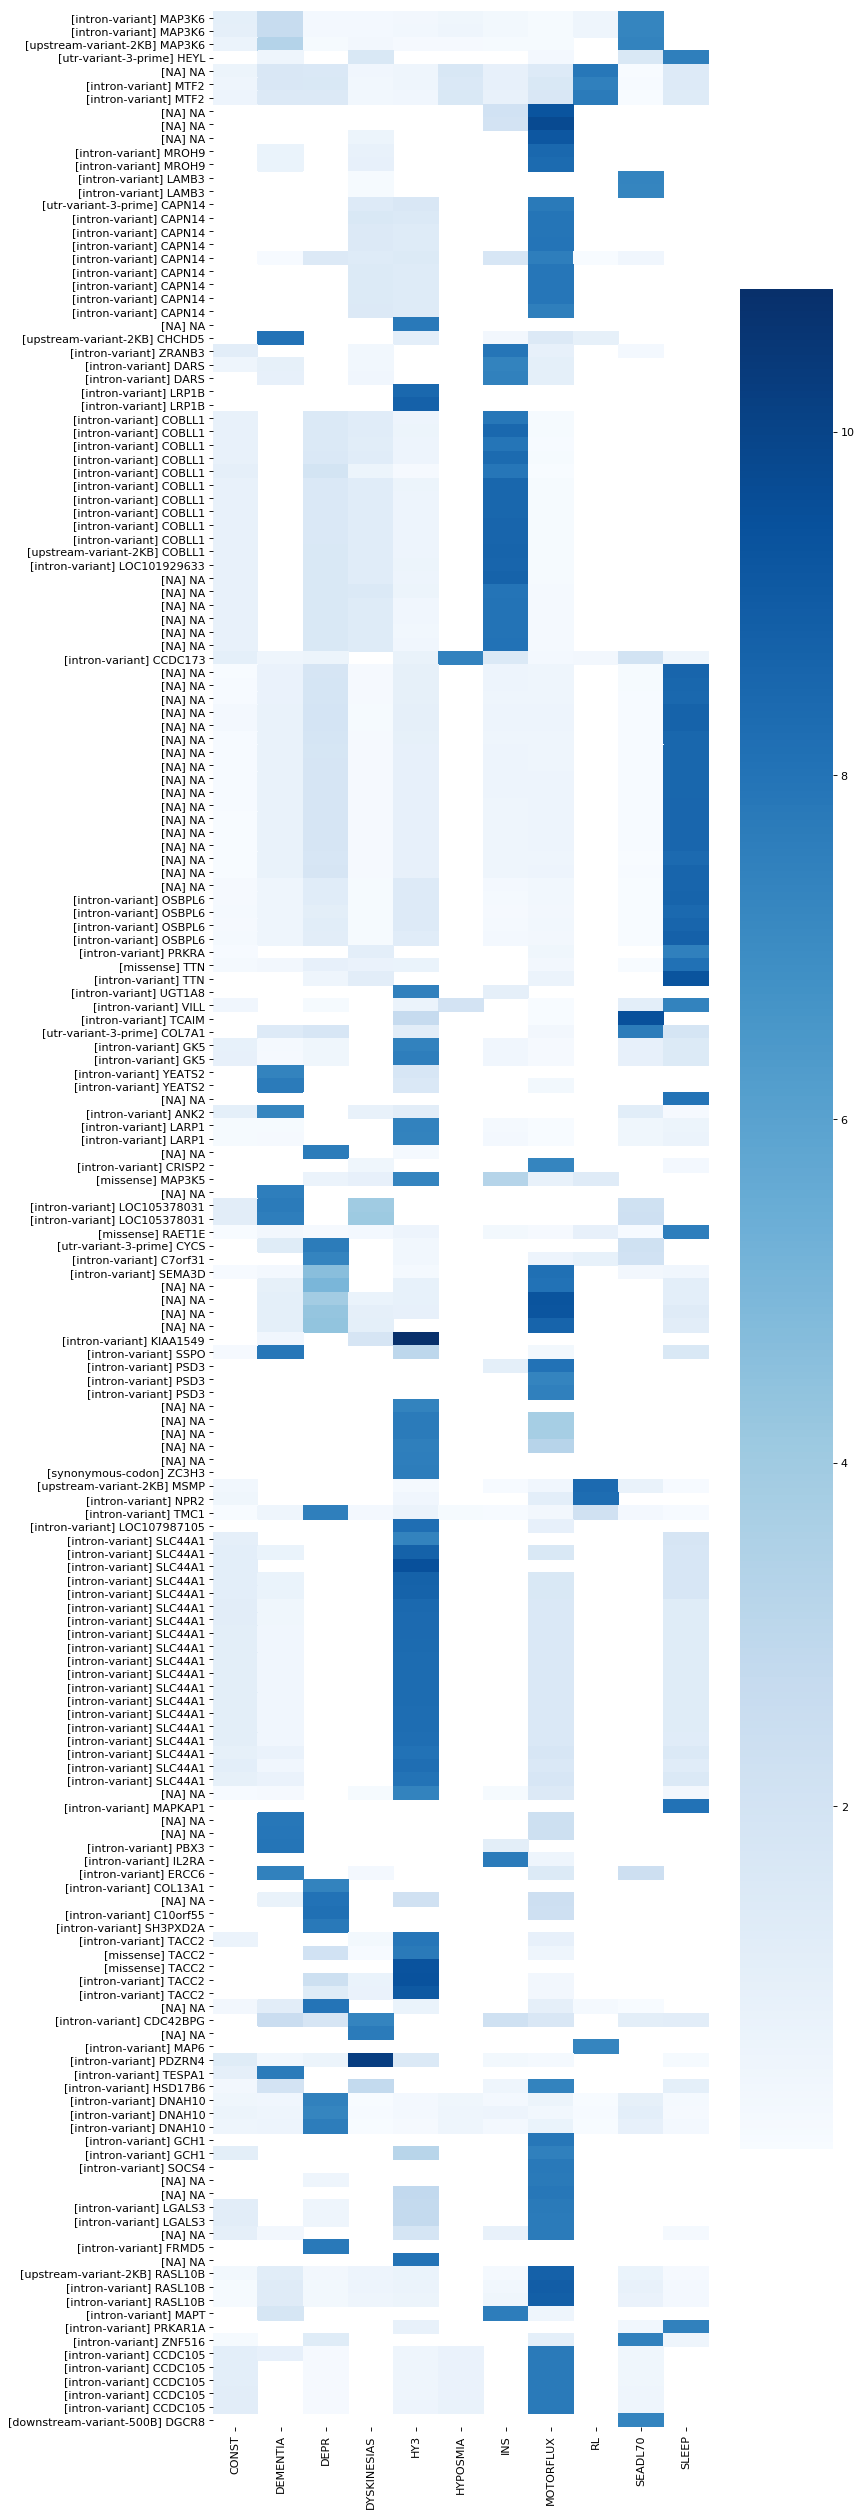

In [331]:
df_out = df.iloc[:, 1:(df.shape[1]-6)]
df_out.index = "[" + df['FXNCLASS'] + "] " + df['SYMBOL'].format(s='dog',n=5,c='x')
df_out.head()
fig=plt.figure(figsize=(10, 40), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(df_out,cmap='Blues')

In [327]:
%%bash
rm -rf /data/LNG/Hirotaka/progGWAS/meta/rvtest/MMSE #MMSE cannot be meta-analyzed
# step1: Get the list of variants
ANALYSIS=rvtest
RES_FOLDER=/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS
for OUTCOME in $(ls $RES_FOLDER);do
    awk '$10 < 5e-8 {print $1}' $RES_FOLDER/$OUTCOME/meta2.tbl > post/sigV_"$ANALYSIS"_"$OUTCOME".list
done

rm: cannot remove ‘/data/LNG/Hirotaka/progGWAS/meta/rvtest/MMSE’: Is a directory


In [ ]:
%%bash
rm -rf post
mkdir -p post
rm /data/LNG/Hirotaka/progGWAS/meta/rvtest/MMSE #MMSE cannot be meta-analyzed
# step1: Get the list of variants
ANALYSIS=surv
RES_FOLDER=/data/LNG/Hirotaka/progGWAS/meta/$ANALYSIS
for OUTCOME in $(ls $RES_FOLDER);do
    awk '$10 < 5e-8 {print $1}' $RES_FOLDER/$OUTCOME/meta2.tbl > post/sigV_"$OUTCOME".list
done
cat post/sigV*.list | sort -u  >> post/sigV.list
rm post/sigV_*.list
echo 'complete step1'

# step2: Get P of the variants from each result (regardless of significant or not)
for OUTCOME in $(ls $RES_FOLDER);do
   grep -f post/sigV.list $RES_FOLDER/$OUTCOME/meta2.tbl | cut -f 1,10 > post/sigV_"$OUTCOME".tbl
done
echo 'complete step2'
# step3: P Cross-tabulated over outcomes
rm -f post/sigV_CrossTab.R
echo '
library(dplyr);library(data.table)
ALLFILES = list.files("post/")
FILES=ALLFILES[grepl("sigV_",ALLFILES)]
OUTCOMES = substring(FILES, 6, nchar(FILES)-4)
for(i in 1:length(OUTCOMES)){
    dt_i = try(fread(paste("post",FILES[i],sep="/"), header=F), silent=T)
    if(class(dt_i)[1]=="try-error"){next}
    names(dt_i) = c("V1",OUTCOMES[i])
    if(i==1){dt = dt_i}else{    dt = full_join(dt, dt_i, by = "V1")}
}
dt2 = dt %>% mutate_at(vars(names(dt)[2:ncol(dt)]), funs(-log10(.)))
write.table(dt2, "post/sigV.tab", row.names = F, quote = F, sep = "\t")
cat("complete step3 \n")
' > post/CrossTab.R
module load R
Rscript --vanilla post/CrossTab.R
rm post/sigV_*
head post/sigV.tab | cut -f 1-5

In [321]:
%%bash
newwall --jobid 6859122 --time 12:00:00

Sucessfully updated 1 job(s).
